<a href="https://colab.research.google.com/github/EugOT/CN-pr-MDD-snRNA-seq/blob/main/notebooks/ClusteringOfPVInterNeurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# These packages are pre-installed on Google Colab, but are included here to facilitate running this notebook locally
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy
!pip install --quiet pacmap
!pip install --quiet leidenalg
!pip install --quiet sinfo
# snRNA-seq analysis
!pip install --quiet scanpy
!pip install --quiet omnipath
!pip install --quiet decoupler

In [16]:
!git clone https://github.com/EugOT/CN-pr-MDD-snRNA-seq.git
%cd /content/CN-pr-MDD-snRNA-seq/

Cloning into 'CN-pr-MDD-snRNA-seq'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 70 (delta 28), reused 23 (delta 12), pack-reused 14 (from 1)
Receiving objects: 100% (70/70), 70.88 MiB | 12.89 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (17/17), done.
Filtering content: 100% (6/6), 391.61 MiB | 24.59 MiB/s, done.
/content/CN-pr-MDD-snRNA-seq


In [17]:
import os
import random
import pacmap
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import decoupler as dc

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from anndata.experimental.multi_files import AnnCollection


matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = ["Helvetica"]
matplotlib.rcParams["figure.max_open_warning"] = 20000

reseed = 42
random.seed(reseed)
np.random.seed(reseed)

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.figdir = PLOTS_DIR
sc.settings.set_figure_params(
    dpi=180, dpi_save=600, vector_friendly=True, format="pdf", transparent=True
)
sc.settings.autoshow = True
sc.settings.autosave = False

In [18]:
samples_females = pd.read_csv("data/PRJNA883411.tsv", delimiter="\t")
samples_females = samples_females[["Run", "Condition", "LibraryName", "BioProject", "Sex", "NTotalCells"]]

In [19]:
filtering_parameters = {
    "hvg_top_genes":6000, #orig: 5000
    "pearson_residuals_top_genes":3000, # orig: 2000
    "min_cells_per_gene":5, #orig: 10
    "min_genes_per_cell":200, #orig: 500
}

females = sc.read_h5ad(
    "data/PRJNA883411-whole_dataset-fpr_0.001-clusters.h5ad"
)
females.obs['Run'] = females.obs['orig.ident']
females.obs = pd.merge(females.obs, samples_females, on="Run", how = "inner").set_index("cell_name", drop=False)
females.uns["name"] = "PRJNA883411"
sc.pp.filter_cells(females, min_genes=filtering_parameters["min_genes_per_cell"])
sc.pp.filter_genes(females, min_cells=filtering_parameters["min_cells_per_gene"])

females.obs = females.obs[[
    'cell_name',
    'background_fraction',
    'droplet_efficiency',
    'doublet_score',
    'nFeature_Diff',
    'nCount_Diff',
    'percent_mito',
    'percent_ribo',
    'percent_mito_ribo',
    'percent_hb',
    'log10GenesPerUMI',
    'k_tree',
    'Run',
    'Condition',
    'BioProject',
    'Sex',
    'n_genes']]

In [20]:
#Filter neurons based on the three gene markers for PV Interneurons

pvalb_gene_index = females.var_names.get_loc('PVALB')
gad1_gene_index = females.var_names.get_loc('GAD1')
gad2_gene_index = females.var_names.get_loc('GAD2')
pv_neurons_mask = (females.X[:, pvalb_gene_index].toarray() > 0) & (females.X[:, gad1_gene_index].toarray() > 0) & (females.X[:, gad2_gene_index].toarray() > 0)
only_pv_neurons = females[pv_neurons_mask]
only_pv_neurons


View of AnnData object with n_obs × n_vars = 306 × 30266
    obs: 'cell_name', 'background_fraction', 'droplet_efficiency', 'doublet_score', 'nFeature_Diff', 'nCount_Diff', 'percent_mito', 'percent_ribo', 'percent_mito_ribo', 'percent_hb', 'log10GenesPerUMI', 'k_tree', 'Run', 'Condition', 'BioProject', 'Sex', 'n_genes'
    var: 'name', 'n_cells'
    uns: 'name'
    obsm: 'X_pacmap', 'X_pca', 'X_umap'

In [21]:
only_pv_neurons.obs.groupby(['Condition'])['cell_name'].count().reset_index()

,Condition,cell_name
0,0,103
1,1,203


In [22]:
adata = only_pv_neurons.copy()
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=filtering_parameters["hvg_top_genes"])
adata = adata[:, adata.var["highly_variable"]]
adata.obs["k_tree"] = adata.obs["Sex"].astype(str) + "_" + adata.obs["k_tree"].astype(str)


<ipython-input-22-148a1313b3af>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["k_tree"] = adata.obs["Sex"].astype(str) + "_" + adata.obs["k_tree"].astype(str)


In [23]:
#keep raw and depth-normalized counts for later
adata.layers["raw"] = adata.X.copy()
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])
adata.raw = adata
sc.experimental.pp.recipe_pearson_residuals(adata, n_top_genes=filtering_parameters["pearson_residuals_top_genes"], batch_key="Run")

In [24]:
hvgs = adata.var["highly_variable"]
embedding = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, apply_pca=False
)
adata.obsm["X_pacmap"] = embedding.fit_transform(adata.obsm["X_pca"], init="pca")
n_cells = len(adata)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50, method='umap')
sc.tl.umap(adata, method='umap')
sc.tl.leiden(adata)

In [25]:
#Trying to find DEGs for either condition

adata.obs['ConditionCategory'] = adata.obs['Condition'].astype('category')
sc.tl.rank_genes_groups(
    adata,
    groupby="ConditionCategory",  # Column defining your groups
    method="t-test",      # You can also try 'logreg', 'wilcoxon', or 't-test_overestim_var'
    key_added="degs_condition"
)

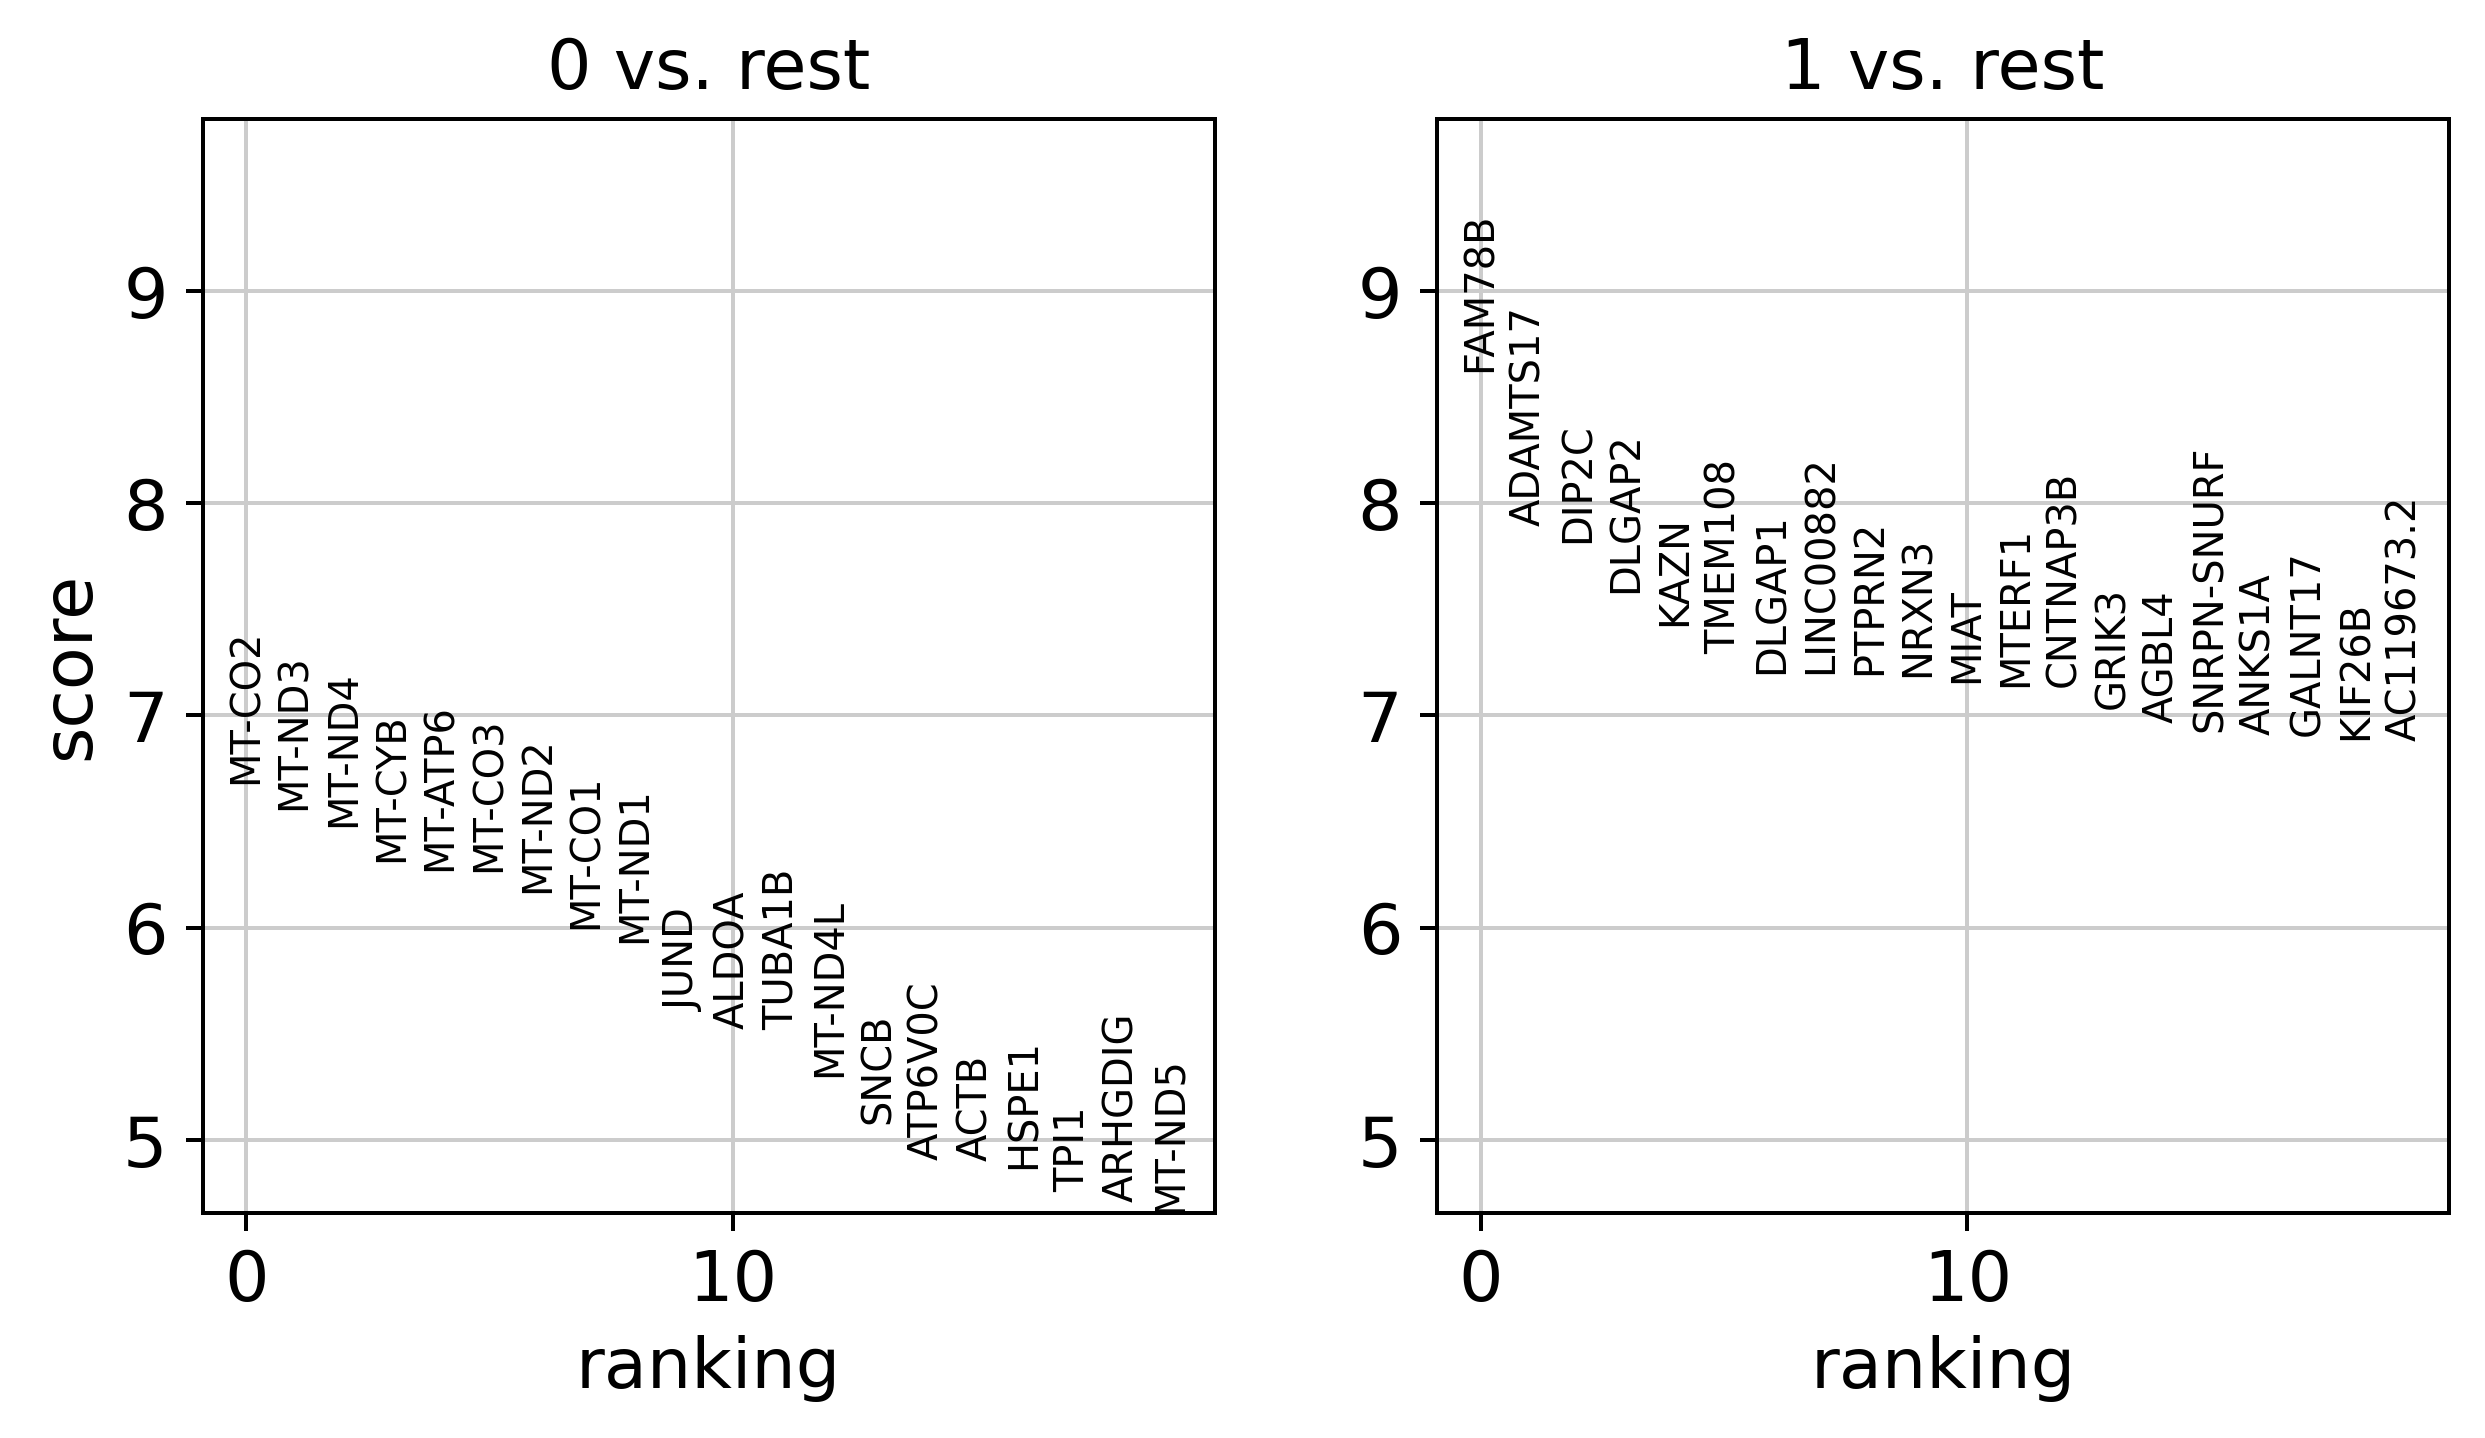

In [26]:
sc.pl.rank_genes_groups(adata, key='degs_condition')

In [27]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', key_added="leiden")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


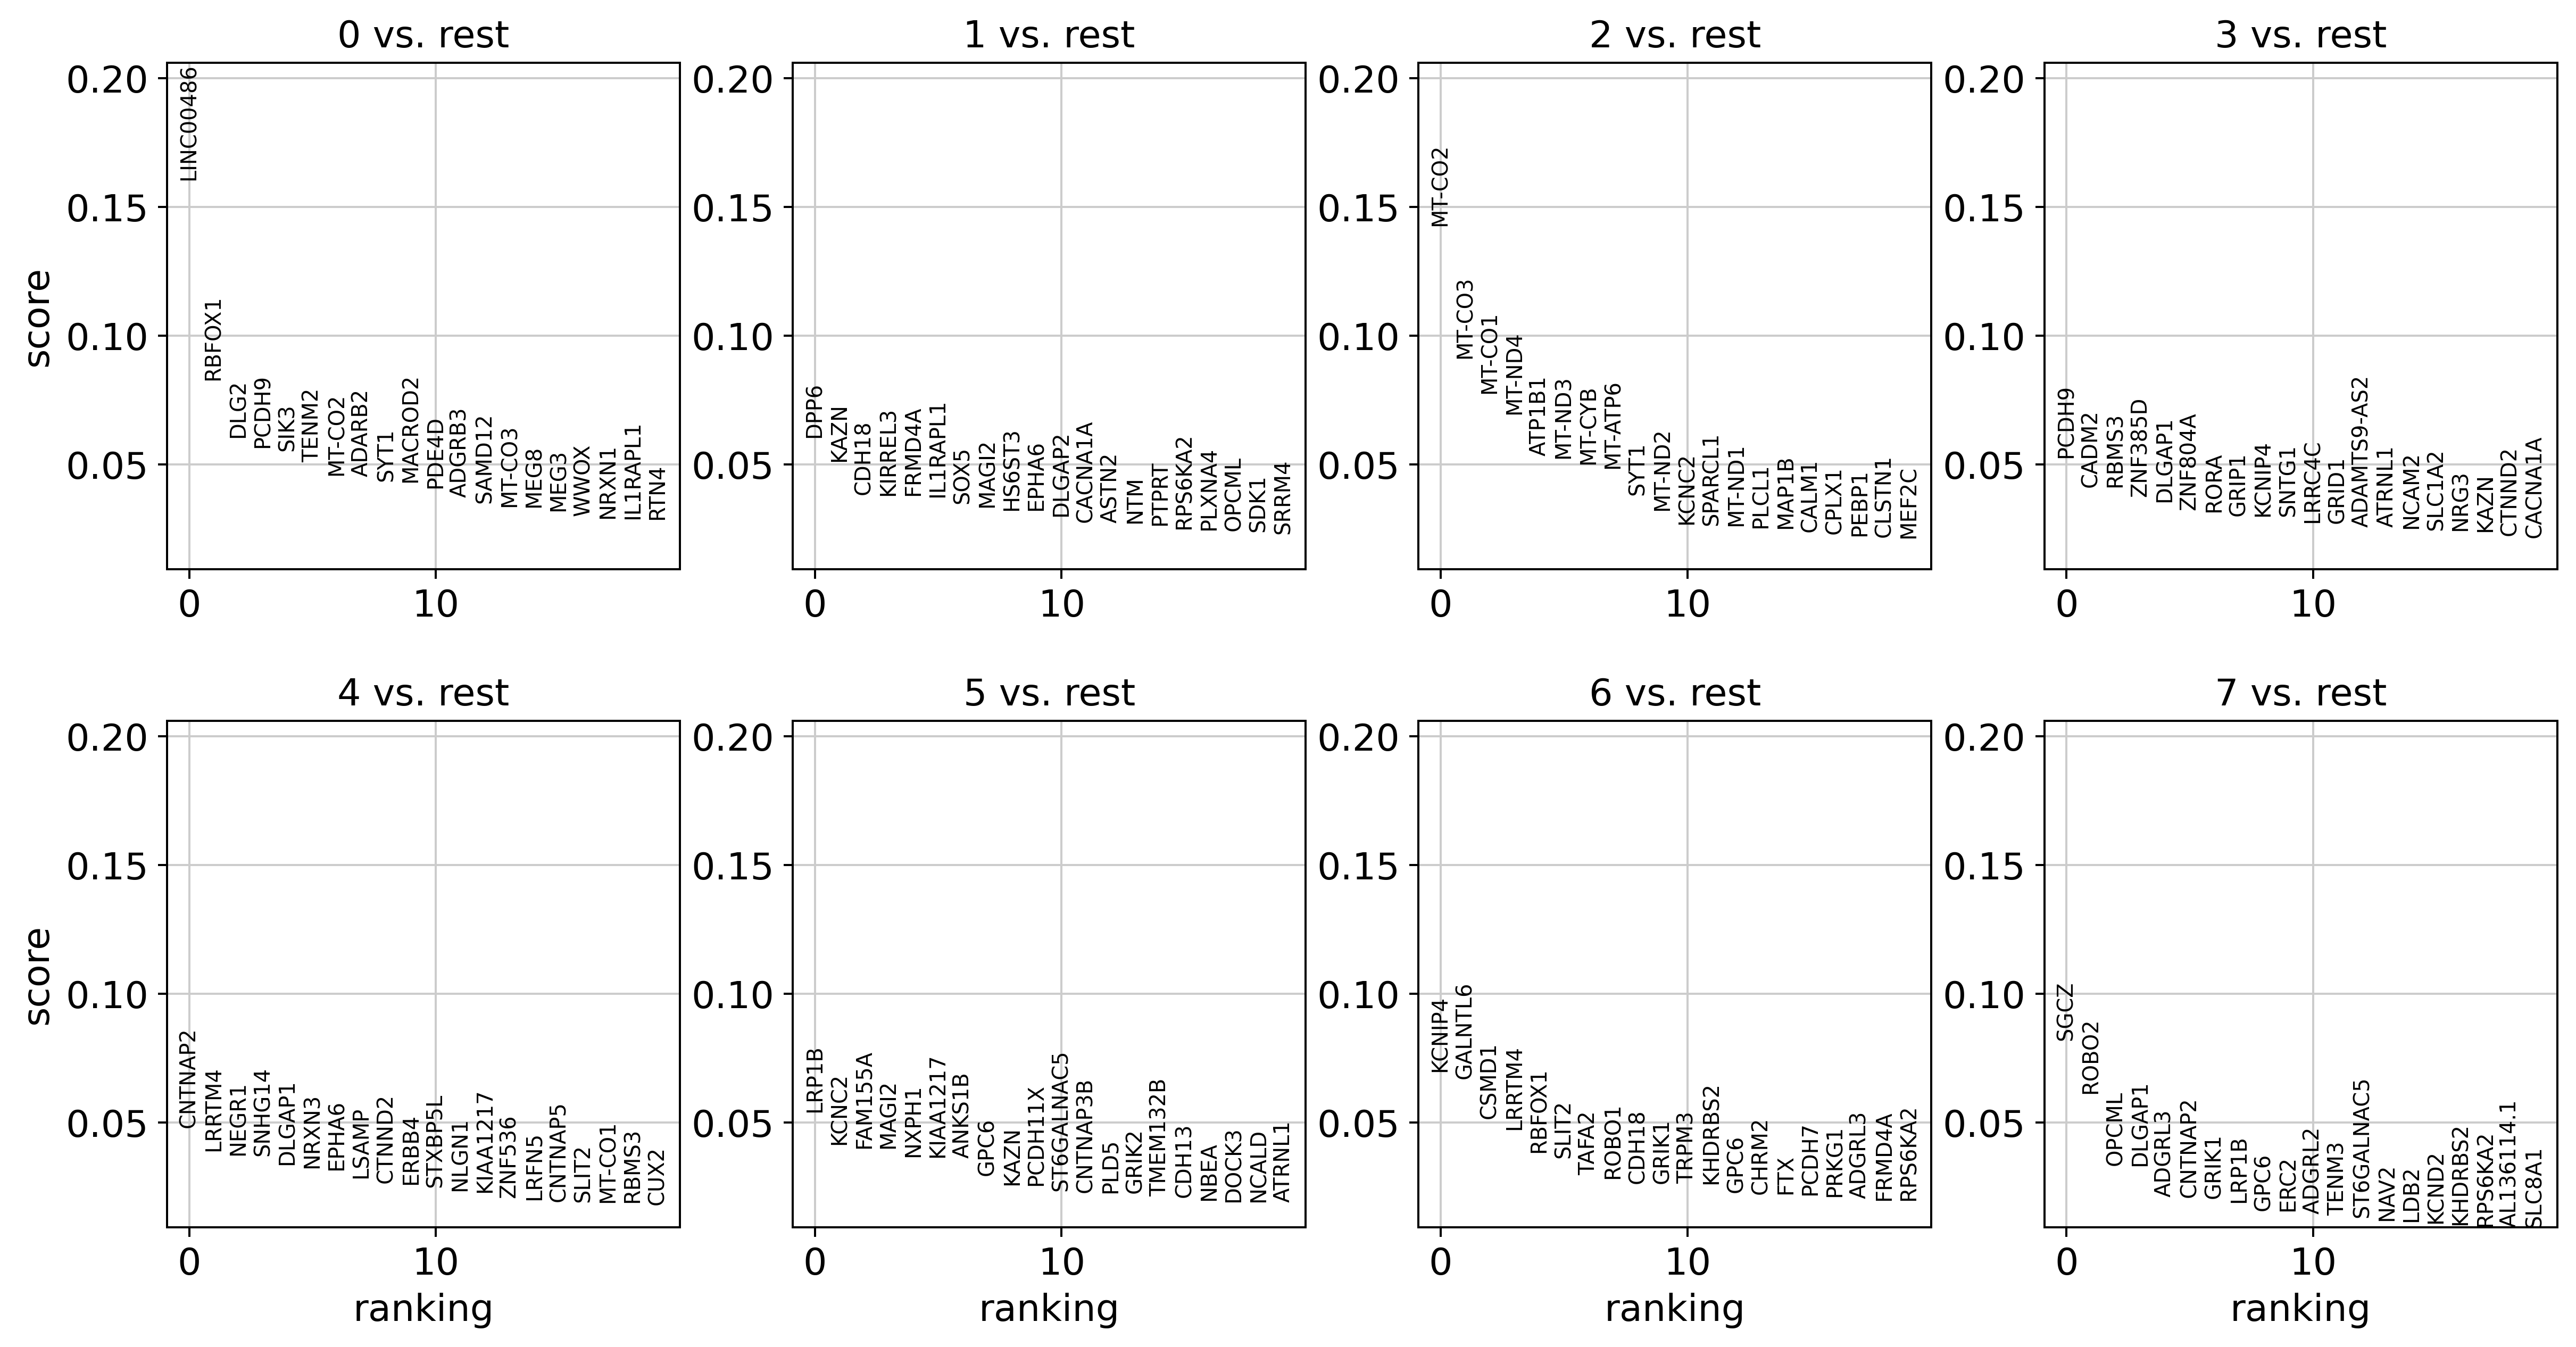

In [28]:
sc.pl.rank_genes_groups(adata, key='leiden')

In [29]:
adata

AnnData object with n_obs × n_vars = 306 × 6000
    obs: 'cell_name', 'background_fraction', 'droplet_efficiency', 'doublet_score', 'nFeature_Diff', 'nCount_Diff', 'percent_mito', 'percent_ribo', 'percent_mito_ribo', 'percent_hb', 'log10GenesPerUMI', 'k_tree', 'Run', 'Condition', 'BioProject', 'Sex', 'n_genes', 'leiden', 'ConditionCategory'
    var: 'name', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'name', 'hvg', 'pca', 'pearson_residuals_normalization', 'neighbors', 'umap', 'leiden', 'degs_condition'
    obsm: 'X_pacmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm'
    obsp: 'distances', 'connectivities'

In [30]:
adata.obs.groupby(["leiden","Condition"])["cell_name"].count().reset_index()

<ipython-input-30-66e58274d72b>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["leiden","Condition"])["cell_name"].count().reset_index()


,leiden,Condition,cell_name
0,0,0,35
1,0,1,21
2,1,0,10
3,1,1,42
4,2,0,36
5,2,1,11
6,3,0,5
7,3,1,42
8,4,0,7
9,4,1,27
